**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


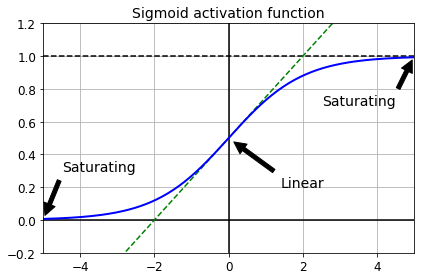

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


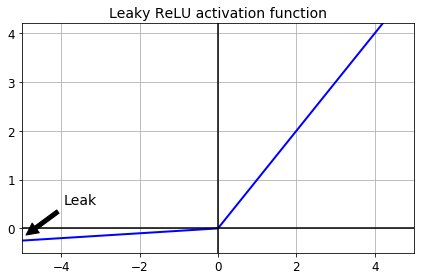

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
layer = keras.layers.Dense(10, activation=leaky_relu)

In [12]:
layer.activation

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation=leaky_relu),
    keras.layers.Dense(100, activation=leaky_relu),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 64us/sample - loss: 1.3979 - accuracy: 0.5948 - val_loss: 0.9369 - val_accuracy: 0.7162
Epoch 2/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.8333 - accuracy: 0.7341 - val_loss: 0.7392 - val_accuracy: 0.7638
Epoch 3/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.7068 - accuracy: 0.7711 - val_loss: 0.6561 - val_accuracy: 0.7906
Epoch 4/10
55000/55000 [==============================] - 3s 55us/sample - loss: 0.6417 - accuracy: 0.7889 - val_loss: 0.6052 - val_accuracy: 0.8088
Epoch 5/10
55000/55000 [==============================] - 3s 56us/sample - loss: 0.5988 - accuracy: 0.8019 - val_loss: 0.5716 - val_accuracy: 0.8166
Epoch 6/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.5686 - accuracy: 0.8118 - val_loss: 0.5465 - val_accuracy: 0.8234
Epoch 7/10
55000/55000 [==============================] -

### ELU

In [17]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


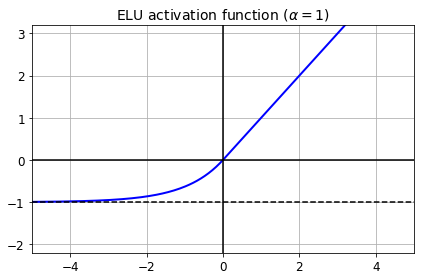

In [18]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [19]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [20]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


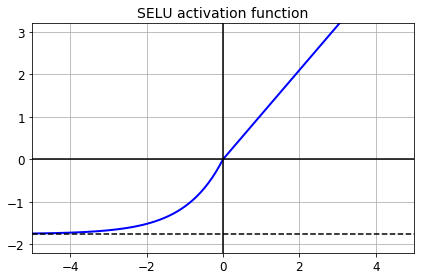

In [22]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [23]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [24]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 35s 644us/sample - loss: 1.0197 - accuracy: 0.6154 - val_loss: 0.7386 - val_accuracy: 0.7348
Epoch 2/5
55000/55000 [==============================] - 33s 607us/sample - loss: 0.7149 - accuracy: 0.7401 - val_loss: 0.6187 - val_accuracy: 0.7774
Epoch 3/5
55000/55000 [==============================] - 32s 583us/sample - loss: 0.6193 - accuracy: 0.7803 - val_loss: 0.5926 - val_accuracy: 0.8036
Epoch 4/5
55000/55000 [==============================] - 32s 586us/sample - loss: 0.5555 - accuracy: 0.8043 - val_loss: 0.5208 - val_accuracy: 0.8262
Epoch 5/5
55000/55000 [==============================] - 32s 573us/sample - loss: 0.5159 - accuracy: 0.8238 - val_loss: 0.4790 - val_accuracy: 0.8358


Now look at what happens if we try to use the ReLU activation function instead:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [33]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 18s 319us/sample - loss: 1.9174 - accuracy: 0.2242 - val_loss: 1.3856 - val_accuracy: 0.3846
Epoch 2/5
55000/55000 [==============================] - 15s 279us/sample - loss: 1.2147 - accuracy: 0.4750 - val_loss: 1.0691 - val_accuracy: 0.5510
Epoch 3/5
55000/55000 [==============================] - 15s 281us/sample - loss: 0.9576 - accuracy: 0.6025 - val_loss: 0.7688 - val_accuracy: 0.7036
Epoch 4/5
55000/55000 [==============================] - 15s 281us/sample - loss: 0.8116 - accuracy: 0.6762 - val_loss: 0.7276 - val_accuracy: 0.7288
Epoch 5/5
55000/55000 [==============================] - 15s 278us/sample - loss: 0.8167 - accuracy: 0.6862 - val_loss: 0.7697 - val_accuracy: 0.7032


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 784)               3136      
_________________________________________________________________
dense_210 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 300)               1200      
_________________________________________________________________
dense_211 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 100)               400       
_________________________________________________________________
dense_212 (Dense)            (None, 10)               

In [36]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_v2/gamma:0', True),
 ('batch_normalization_v2/beta:0', True),
 ('batch_normalization_v2/moving_mean:0', False),
 ('batch_normalization_v2/moving_variance:0', False)]

In [37]:
bn1.updates

ListWrapper([<tf.Operation 'batch_normalization_v2/cond_2/Identity' type=Identity>, <tf.Operation 'batch_normalization_v2/cond_3/Identity' type=Identity>])

In [38]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.8756 - accuracy: 0.7140 - val_loss: 0.5514 - val_accuracy: 0.8212
Epoch 2/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5765 - accuracy: 0.8033 - val_loss: 0.4742 - val_accuracy: 0.8436
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.5146 - accuracy: 0.8216 - val_loss: 0.4382 - val_accuracy: 0.8530
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4821 - accuracy: 0.8322 - val_loss: 0.4170 - val_accuracy: 0.8604
Epoch 5/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4589 - accuracy: 0.8402 - val_loss: 0.4003 - val_accuracy: 0.8658
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4428 - accuracy: 0.8459 - val_loss: 0.3883 - val_accuracy: 0.8698
Epoch 7/10
55000/55000 [==============================] -

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [41]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [42]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 89us/sample - loss: 0.8617 - accuracy: 0.7095 - val_loss: 0.5649 - val_accuracy: 0.8102
Epoch 2/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.5803 - accuracy: 0.8015 - val_loss: 0.4833 - val_accuracy: 0.8344
Epoch 3/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.5153 - accuracy: 0.8208 - val_loss: 0.4463 - val_accuracy: 0.8462
Epoch 4/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4846 - accuracy: 0.8307 - val_loss: 0.4256 - val_accuracy: 0.8530
Epoch 5/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.4576 - accuracy: 0.8402 - val_loss: 0.4106 - val_accuracy: 0.8590
Epoch 6/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4401 - accuracy: 0.8467 - val_loss: 0.3973 - val_accuracy: 0.8610
Epoch 7/10
55000/55000 [==============================] -

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [43]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [44]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [45]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [46]:
X_train_A.shape

(43986, 28, 28)

In [47]:
X_train_B.shape

(200, 28, 28)

In [48]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [49]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

In [51]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [52]:
model_A.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [53]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 3s 78us/sample - loss: 0.5887 - accuracy: 0.8123 - val_loss: 0.3749 - val_accuracy: 0.8734
Epoch 2/20
43986/43986 [==============================] - 3s 69us/sample - loss: 0.3516 - accuracy: 0.8793 - val_loss: 0.3223 - val_accuracy: 0.8874
Epoch 3/20
43986/43986 [==============================] - 3s 68us/sample - loss: 0.3160 - accuracy: 0.8894 - val_loss: 0.3009 - val_accuracy: 0.8956
Epoch 4/20
43986/43986 [==============================] - 3s 70us/sample - loss: 0.2963 - accuracy: 0.8979 - val_loss: 0.2850 - val_accuracy: 0.9036
Epoch 5/20
43986/43986 [==============================] - 3s 68us/sample - loss: 0.2825 - accuracy: 0.9035 - val_loss: 0.2767 - val_accuracy: 0.9076
Epoch 6/20
43986/43986 [==============================] - 3s 69us/sample - loss: 0.2720 - accuracy: 0.9068 - val_loss: 0.2672 - val_accuracy: 0.9093
Epoch 7/20
43986/43986 [==============================] -

In [54]:
model_A.save("my_model_A.h5")

In [55]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [56]:
model_B.compile(loss="binary_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [57]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 0s 2ms/sample - loss: 0.9537 - accuracy: 0.4800 - val_loss: 0.6472 - val_accuracy: 0.5710
Epoch 2/20
200/200 [==============================] - 0s 318us/sample - loss: 0.5805 - accuracy: 0.6850 - val_loss: 0.4863 - val_accuracy: 0.8428
Epoch 3/20
200/200 [==============================] - 0s 318us/sample - loss: 0.4561 - accuracy: 0.8750 - val_loss: 0.4116 - val_accuracy: 0.8905
Epoch 4/20
200/200 [==============================] - 0s 308us/sample - loss: 0.3885 - accuracy: 0.9100 - val_loss: 0.3650 - val_accuracy: 0.9148
Epoch 5/20
200/200 [==============================] - 0s 311us/sample - loss: 0.3426 - accuracy: 0.9250 - val_loss: 0.3308 - val_accuracy: 0.9270
Epoch 6/20
200/200 [==============================] - 0s 317us/sample - loss: 0.3084 - accuracy: 0.9300 - val_loss: 0.3044 - val_accuracy: 0.9371
Epoch 7/20
200/200 [==============================] - 0s 309us/sample - loss: 0.

In [58]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 784)               3136      
_________________________________________________________________
dense_213 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_214 (Dense)            (None, 100)               30100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)              

In [59]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [60]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [61]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd",
                     metrics=["accuracy"])

In [62]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd",
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 0.5851 - accuracy: 0.6600 - val_loss: 0.5855 - val_accuracy: 0.6318
Epoch 2/4
200/200 [==============================] - 0s 303us/sample - loss: 0.5484 - accuracy: 0.6850 - val_loss: 0.5484 - val_accuracy: 0.6775
Epoch 3/4
200/200 [==============================] - 0s 294us/sample - loss: 0.5116 - accuracy: 0.7250 - val_loss: 0.5141 - val_accuracy: 0.7160
Epoch 4/4
200/200 [==============================] - 0s 316us/sample - loss: 0.4779 - accuracy: 0.7450 - val_loss: 0.4859 - val_accuracy: 0.7363
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 2ms/sample - loss: 0.3989 - accuracy: 0.8050 - val_loss: 0.3419 - val_accuracy: 0.8702
Epoch 2/16
200/200 [==============================] - 0s 328us/sample - loss: 0.2795 - accuracy: 0.9300 - val_loss: 0.2624 - val_accuracy: 0.9280
Epoch 3/16
200/200 [====================

So, what's the final verdict?

In [63]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 41us/sample - loss: 0.1431 - accuracy: 0.9705


[0.1430660070180893, 0.9705]

In [64]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 38us/sample - loss: 0.0689 - accuracy: 0.9925


[0.06887910133600235, 0.9925]

Great! We got quite a bit of transfer: the error rate dropped by a factor of almost 4!

In [65]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337

# Faster Optimizers

## Momentum optimization

In [66]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [68]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [69]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [70]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [71]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [72]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [73]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [75]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 66us/sample - loss: 0.4840 - accuracy: 0.8296 - val_loss: 0.4038 - val_accuracy: 0.8630
Epoch 2/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3787 - accuracy: 0.8653 - val_loss: 0.3846 - val_accuracy: 0.8706
Epoch 3/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3461 - accuracy: 0.8770 - val_loss: 0.3606 - val_accuracy: 0.8776
Epoch 4/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3248 - accuracy: 0.8844 - val_loss: 0.3661 - val_accuracy: 0.8738
Epoch 5/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3092 - accuracy: 0.8902 - val_loss: 0.3516 - val_accuracy: 0.8792
Epoch 6/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.2967 - accuracy: 0.8938 - val_loss: 0.3467 - val_accuracy: 0.8810
Epoch 7/25
55000/55000 [==============================] -

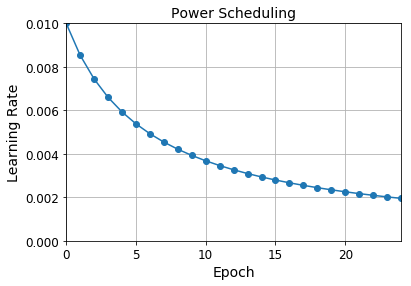

In [76]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [77]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [78]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [79]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [80]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 107us/sample - loss: 0.8245 - accuracy: 0.7595 - val_loss: 1.0870 - val_accuracy: 0.7106
Epoch 2/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.6391 - accuracy: 0.8064 - val_loss: 0.6125 - val_accuracy: 0.8160
Epoch 3/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.5962 - accuracy: 0.8174 - val_loss: 0.6526 - val_accuracy: 0.8086
Epoch 4/25
55000/55000 [==============================] - 5s 99us/sample - loss: 0.5420 - accuracy: 0.8306 - val_loss: 0.7521 - val_accuracy: 0.7766
Epoch 5/25
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4853 - accuracy: 0.8460 - val_loss: 0.5616 - val_accuracy: 0.8314
Epoch 6/25
55000/55000 [==============================] - 5s 98us/sample - loss: 0.4443 - accuracy: 0.8571 - val_loss: 0.5430 - val_accuracy: 0.8664
Epoch 7/25
55000/55000 [=============================

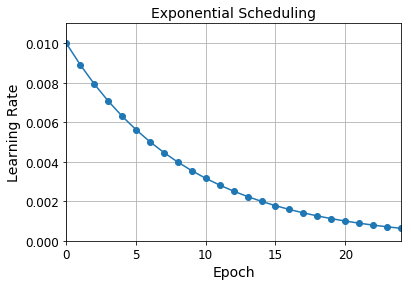

In [81]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [82]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [83]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 132us/sample - loss: 0.8067 - accuracy: 0.7678 - val_loss: 0.7942 - val_accuracy: 0.7780
Epoch 2/25
55000/55000 [==============================] - 7s 122us/sample - loss: 0.6784 - accuracy: 0.7937 - val_loss: 0.8375 - val_accuracy: 0.8120
Epoch 3/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.6060 - accuracy: 0.8148 - val_loss: 0.6303 - val_accuracy: 0.8304
Epoch 4/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.5279 - accuracy: 0.8341 - val_loss: 0.5724 - val_accuracy: 0.8196
Epoch 5/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4803 - accuracy: 0.8486 - val_loss: 0.5488 - val_accuracy: 0.8486
Epoch 6/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4305 - accuracy: 0.8611 - val_loss: 0.4778 - val_accuracy: 0.8470
Epoch 7/25
55000/55000 [===========================

In [84]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

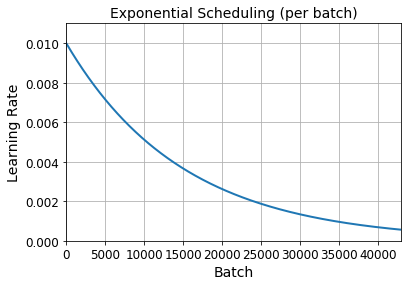

In [85]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [86]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [87]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [88]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 111us/sample - loss: 0.8151 - accuracy: 0.7655 - val_loss: 0.6868 - val_accuracy: 0.7780
Epoch 2/25
55000/55000 [==============================] - 6s 102us/sample - loss: 0.8153 - accuracy: 0.7659 - val_loss: 1.0604 - val_accuracy: 0.7148
Epoch 3/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.9138 - accuracy: 0.7218 - val_loss: 1.3223 - val_accuracy: 0.6660
Epoch 4/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.8506 - accuracy: 0.7627 - val_loss: 0.6807 - val_accuracy: 0.8174
Epoch 5/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.7213 - accuracy: 0.8068 - val_loss: 1.0441 - val_accuracy: 0.8030
Epoch 6/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.4882 - accuracy: 0.8548 - val_loss: 0.5411 - val_accuracy: 0.8494
Epoch 7/25
55000/55000 [===========================

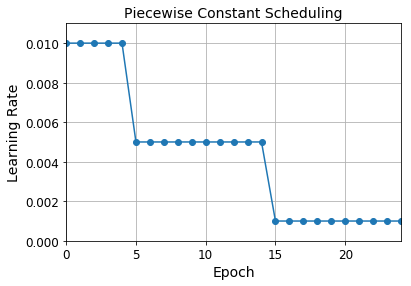

In [89]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [90]:
tf.random.set_seed(42)
np.random.seed(42)

In [91]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 79us/sample - loss: 0.5954 - accuracy: 0.8055 - val_loss: 0.5432 - val_accuracy: 0.8154
Epoch 2/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5194 - accuracy: 0.8345 - val_loss: 0.5184 - val_accuracy: 0.8468
Epoch 3/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5080 - accuracy: 0.8453 - val_loss: 0.5780 - val_accuracy: 0.8384
Epoch 4/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5360 - accuracy: 0.8452 - val_loss: 0.7195 - val_accuracy: 0.8350
Epoch 5/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5239 - accuracy: 0.8504 - val_loss: 0.5219 - val_accuracy: 0.8562
Epoch 6/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5163 - accuracy: 0.8528 - val_loss: 0.5669 - val_accuracy: 0.8382
Epoch 7/25
55000/55000 [==============================] -

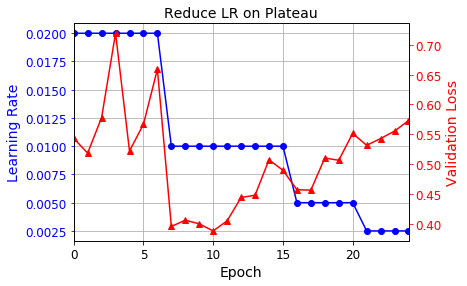

In [92]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [93]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4887 - accuracy: 0.8282 - val_loss: 0.4245 - val_accuracy: 0.8526
Epoch 2/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3830 - accuracy: 0.8641 - val_loss: 0.3798 - val_accuracy: 0.8688
Epoch 3/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3491 - accuracy: 0.8758 - val_loss: 0.3650 - val_accuracy: 0.8730
Epoch 4/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3267 - accuracy: 0.8839 - val_loss: 0.3564 - val_accuracy: 0.8746
Epoch 5/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3102 - accuracy: 0.8893 - val_loss: 0.3493 - val_accuracy: 0.8770
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2969 - accuracy: 0.8939 - val_loss: 0.3400 - val_accuracy: 0.8818
Epoch 7/25
55000/55000 [==============================] -

For piecewise constant scheduling, try this:

In [94]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch], values=[0.01, 0.005, 0.001])

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [95]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [96]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 128us/sample - loss: 1.6073 - accuracy: 0.8112 - val_loss: 0.7314 - val_accuracy: 0.8242
Epoch 2/2
55000/55000 [==============================] - 6s 117us/sample - loss: 0.7193 - accuracy: 0.8256 - val_loss: 0.7029 - val_accuracy: 0.8304


In [97]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 129us/sample - loss: 1.6597 - accuracy: 0.8128 - val_loss: 0.7630 - val_accuracy: 0.8080
Epoch 2/2
55000/55000 [==============================] - 7s 124us/sample - loss: 0.7176 - accuracy: 0.8271 - val_loss: 0.6848 - val_accuracy: 0.8360


## Dropout

In [98]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 145us/sample - loss: 0.5741 - accuracy: 0.8030 - val_loss: 0.3841 - val_accuracy: 0.8572
Epoch 2/2
55000/55000 [==============================] - 7s 134us/sample - loss: 0.4218 - accuracy: 0.8469 - val_loss: 0.3534 - val_accuracy: 0.8728


## Alpha Dropout

In [99]:
tf.random.set_seed(42)
np.random.seed(42)

In [100]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 111us/sample - loss: 0.6639 - accuracy: 0.7582 - val_loss: 0.5840 - val_accuracy: 0.8410
Epoch 2/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.5517 - accuracy: 0.7968 - val_loss: 0.5747 - val_accuracy: 0.8430
Epoch 3/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5260 - accuracy: 0.8062 - val_loss: 0.5233 - val_accuracy: 0.8486
Epoch 4/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5055 - accuracy: 0.8136 - val_loss: 0.4687 - val_accuracy: 0.8606
Epoch 5/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.4897 - accuracy: 0.8187 - val_loss: 0.5188 - val_accuracy: 0.8588
Epoch 6/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.4812 - accuracy: 0.8217 - val_loss: 0.4929 - val_accuracy: 0.8508
Epoch 7/20
55000/55000 [==============================] 

In [101]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 39us/sample - loss: 0.4535 - accuracy: 0.8680


[0.45350628316402436, 0.868]

In [102]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 2s 41us/sample - loss: 0.3357 - accuracy: 0.8887


[0.335701530437036, 0.88872725]

In [103]:
#with keras.backend.learning_phase_scope(1):  # TODO: check https://github.com/tensorflow/tensorflow/issues/25754
#    history = model.fit(X_train_scaled, y_train)

## MC Dropout

In [104]:
tf.random.set_seed(42)
np.random.seed(42)

In [105]:
with keras.backend.learning_phase_scope(1):  # TODO: check https://github.com/tensorflow/tensorflow/issues/25754
    y_probas = np.stack([model.predict(X_test_scaled) for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [106]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [107]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0

In [108]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [109]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [110]:
y_pred = np.argmax(y_proba, axis=1)

In [111]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.868

In [112]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [113]:
tf.random.set_seed(42)
np.random.seed(42)

In [114]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [115]:
mc_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout_3 (MCAlphaD (None, 784)               0         
_________________________________________________________________
dense_311 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_4 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_312 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_5 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 10)              

In [116]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [117]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [118]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.19, 0.  , 0.64]],
      dtype=float32)

## Max norm

In [119]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [120]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 147us/sample - loss: 0.4745 - accuracy: 0.8329 - val_loss: 0.3988 - val_accuracy: 0.8584
Epoch 2/2
55000/55000 [==============================] - 7s 135us/sample - loss: 0.3554 - accuracy: 0.8688 - val_loss: 0.3681 - val_accuracy: 0.8726


# Exercises

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use the `keras.layers.concatenate()` function to concatenate the outputs of both DNNs, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._